In [ ]:
!pip install decord torch bitsandbytes accelerate transformers

In [ ]:
from pprint import pprint

import numpy as np
import torch
from matplotlib import pyplot as plt

import decord
from decord import VideoReader, cpu
from decord import cpu, gpu

from transformers import (
    LlavaNextVideoForConditionalGeneration,
    LlavaNextVideoProcessor,
    BitsAndBytesConfig,
    GenerationConfig
)
from sentence_transformers import SentenceTransformer

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
import tarfile

file = tarfile.open('/content/drive/MyDrive/video_pairs.tar.gz')

file.extractall('/content')
file.close()

## Test the video readed using decord

In [ ]:
video_1 = "/content/video_pairs/589_014.mp4"
video_2 = "/content/video_pairs/4753_024.mp4"

In [ ]:
with open(video_1, 'rb') as f:
  vr1 = VideoReader(f, ctx=cpu(0))
print('video frames:', len(vr1))

video frames: 180


In [ ]:
with open(video_2, 'rb') as f:
  vr2 = VideoReader(f, ctx=cpu(0))
print('video frames:', len(vr2))

video frames: 503


In [ ]:
decord.bridge.set_bridge('torch')

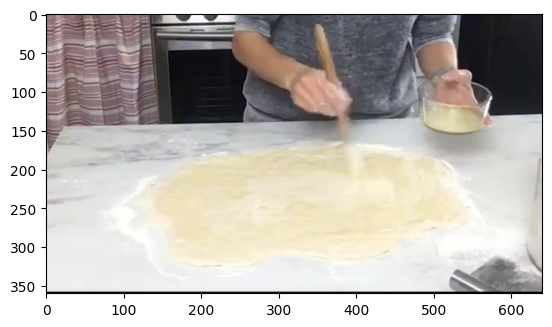

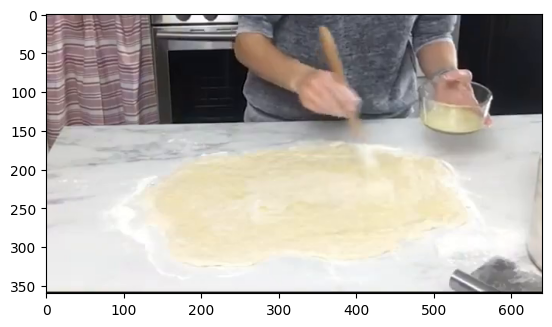

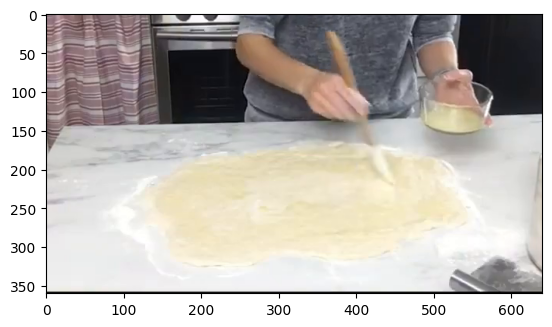

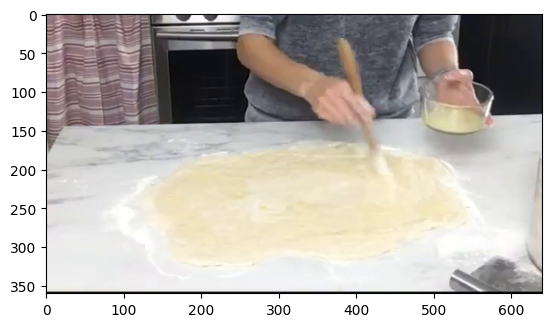

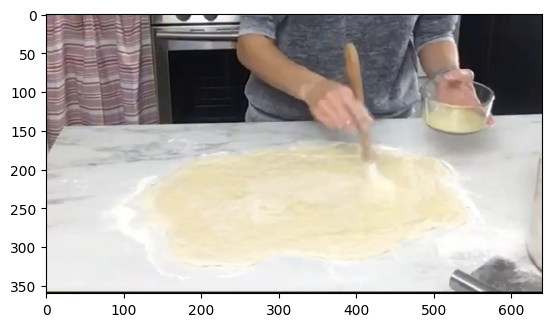

In [ ]:
vr_slice = vr1[:5]
for i in range(len(vr_slice)):
  frame = vr1[i]
  plt.imshow(frame)
  plt.show()

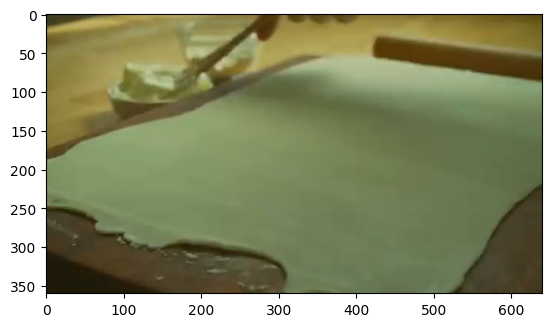

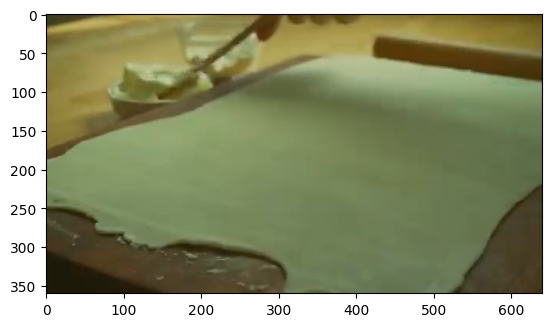

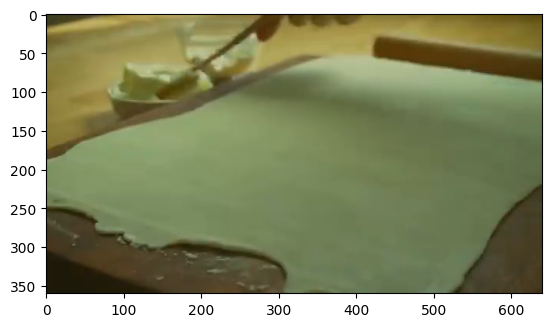

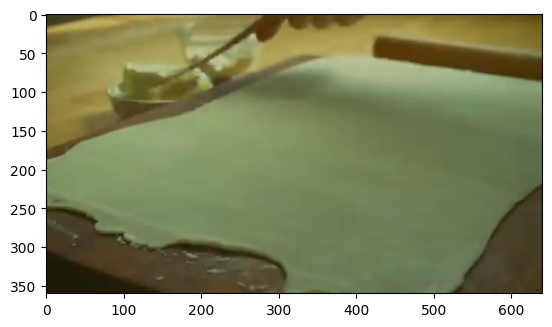

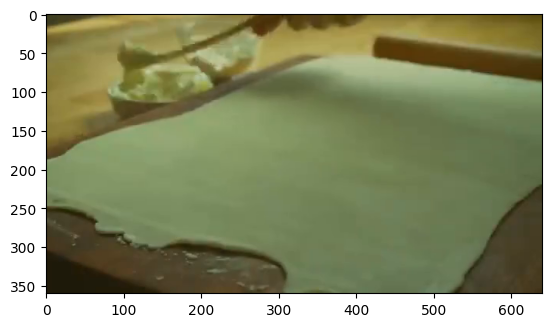

In [ ]:
vr_slice = vr2[:5]
for i in range(len(vr_slice)):
  frame = vr2[i]
  plt.imshow(frame)
  plt.show()

## Load the VLLM and test it on a video

In [ ]:
def load_model(model_path:str = "llava-hf/LLaVA-NeXT-Video-7B-hf",
               use_quantization: bool = False,
               device: str = "auto") -> tuple:
    """
    Loads a model with or without quantization depending on the `use_quantization` flag.
    """
    # Define quantization config (4-bit recommended for Colab)
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,              # or set to False for 8-bit
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"       # `nf4` is better than `fp4`
    )

    # Load model with or without quantization
    if use_quantization:
        model = LlavaNextVideoForConditionalGeneration.from_pretrained(
            model_path,
            quantization_config=bnb_config,
            device_map=device
        )
    else:
        model = LlavaNextVideoForConditionalGeneration.from_pretrained(
            model_path,
            device_map=device
        )

    # Load the processor (no quantization needed here)
    processor = LlavaNextVideoProcessor.from_pretrained(model_path)

    return model, processor

In [ ]:
model_path = "llava-hf/LLaVA-NeXT-Video-7B-hf" # temperature is not applicable for this model
model, processor = load_model(model_path, use_quantization=True)

In [ ]:
def read_video_decord(video_path: str = None, num_frames: int = 8) -> np.ndarray:
    '''
    Read and sample frames from a video using Decord.
    '''
    vr = VideoReader(video_path, ctx=cpu(0))
    total_frames = len(vr) # 30 60 ...
    indices = np.linspace(0, total_frames - 1, num=num_frames).astype(int)
    frames = vr.get_batch(indices)  # This is a decord NDArray or torch.Tensor

    # Convert to numpy
    if hasattr(frames, 'asnumpy'):
        return frames.asnumpy()
    elif hasattr(frames, 'numpy'):
        return frames.numpy()
    else:
        return frames.detach().cpu().numpy()

In [ ]:
# Load the video as an np.array, sampling uniformly 8 frames (can sample more for longer videos)
video_1_path = '/content/video_pairs/589_014.mp4'
video_2_path = '/content/video_pairs/4753_024.mp4'

video_1 = read_video_decord(video_1_path, num_frames=8)
video_2 = read_video_decord(video_2_path, num_frames=8)

Visualise the frames that are passed into the model

In [ ]:
def visualise_frames(video: np.ndarray = None) -> None:
    """
    Visualizes each frame in the given video array.
    """

    decord.bridge.set_bridge('torch')

    for i in range(len(video)):
      frame = video[i]
      plt.imshow(frame)
      plt.show()

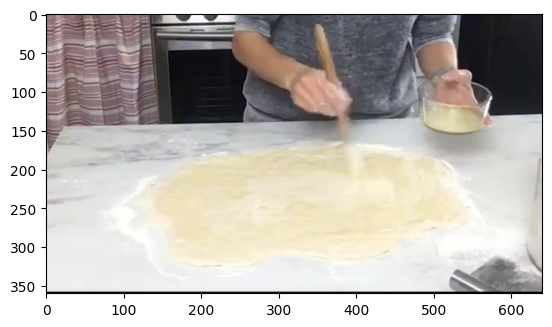

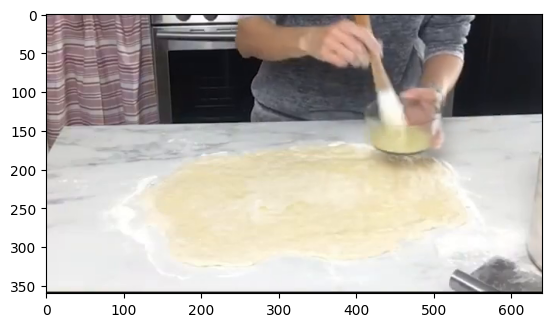

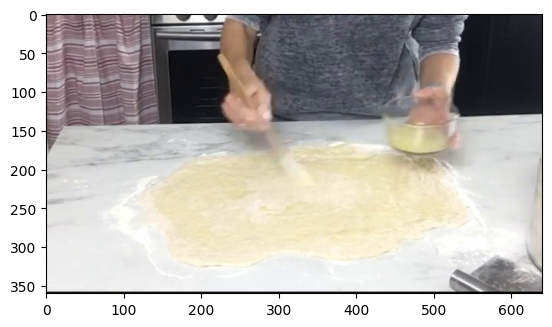

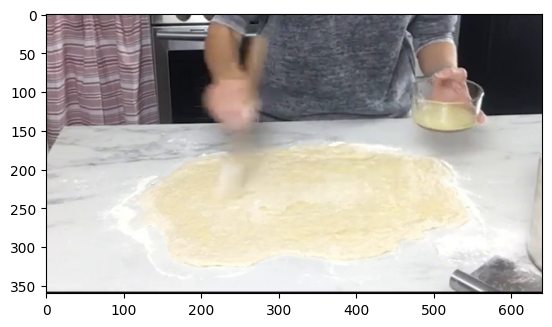

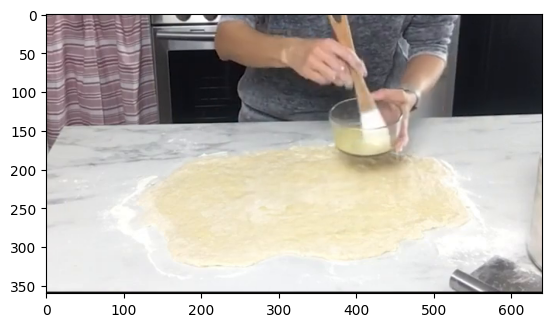

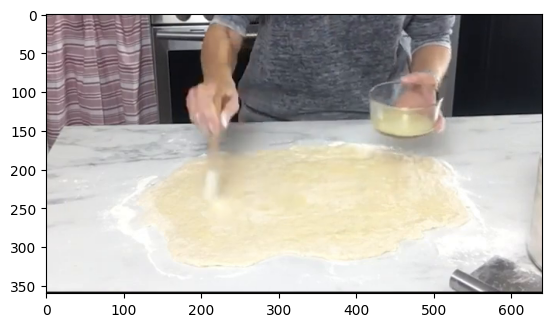

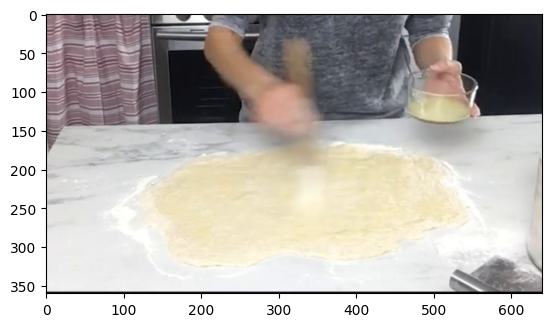

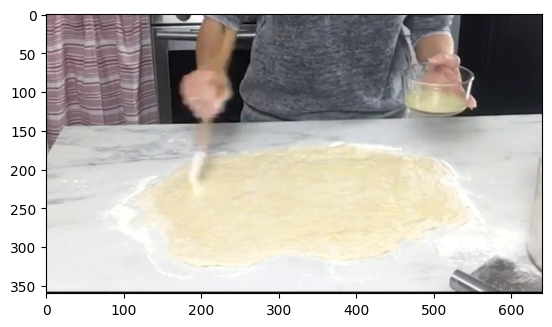

In [ ]:
visualise_frames(video_1)

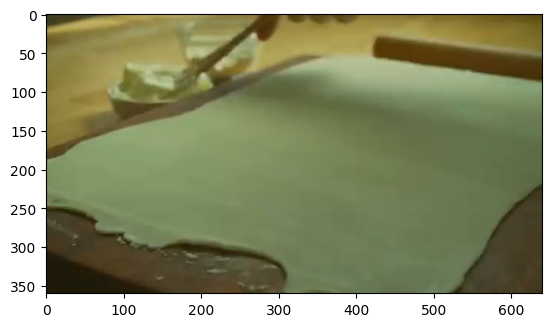

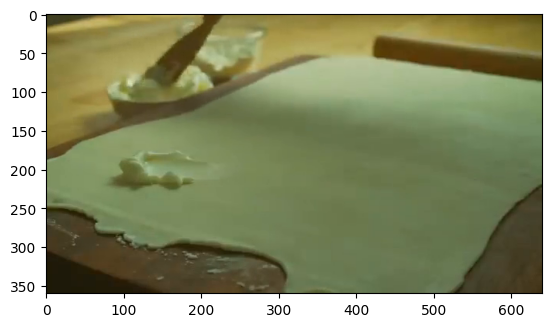

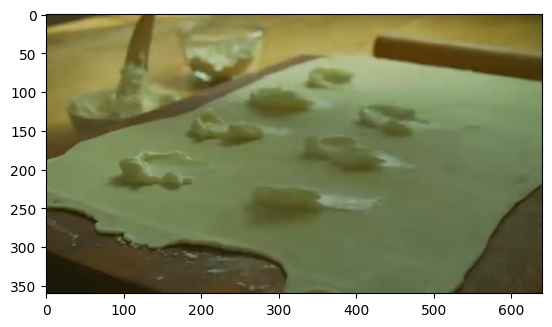

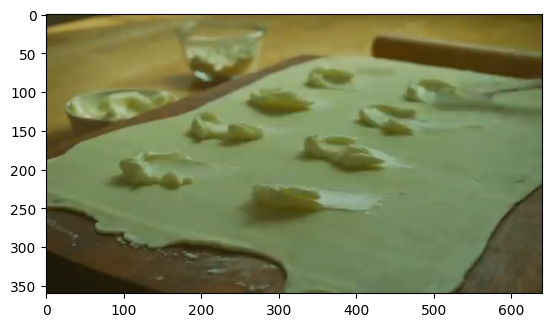

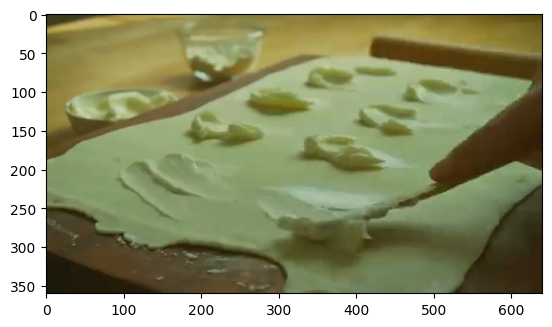

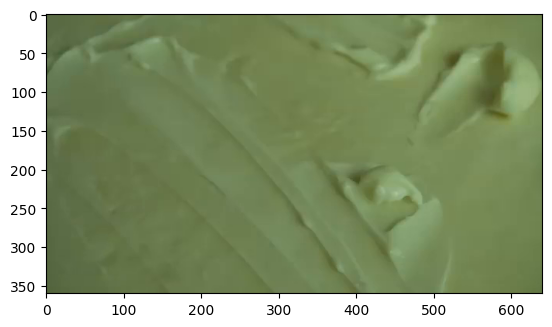

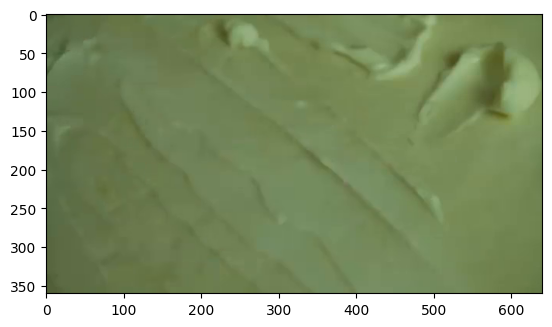

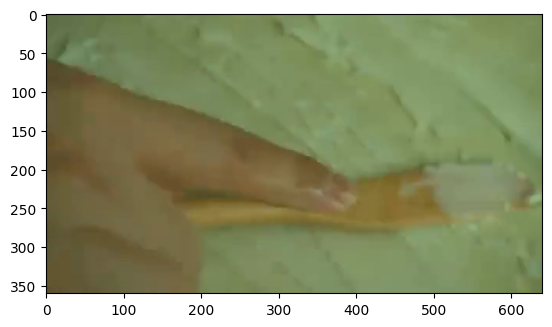

In [ ]:
visualise_frames(video_2)

In [ ]:
def generate_video_response(conversation: list = None,
                            video: np.ndarray = None,
                            model: None = None,
                            processor: None = None,
                            max_tokens: int = 512,
                            device: str = 'cuda:0') -> list:
    """
    Generates a response from the model based on the provided conversation and video input.
    """

    prompt = processor.apply_chat_template(conversation,
                                           add_generation_prompt=True)

    if video is not None:
        inputs = processor(text=prompt, videos=video, return_tensors="pt")
    else:
        inputs = processor(text=prompt, return_tensors="pt")

    out = model.generate(**inputs.to(device), max_new_tokens=max_tokens)

    output = processor.batch_decode(out, skip_special_tokens=True,
                                    clean_up_tokenization_spaces=True)

    response = output[0].split("ASSISTANT:")[-1].strip()

    return response

### Approach 1: Stacking frames of two videos

Stack frames of two videos to pass them to the model for comparison

In [ ]:
combined_video = np.concatenate([video_1, video_2], axis=0)

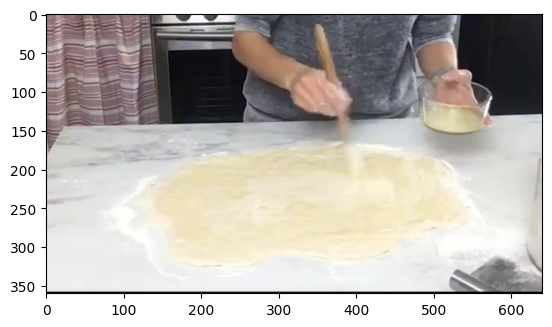

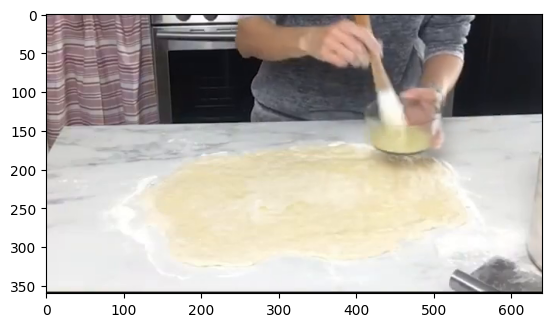

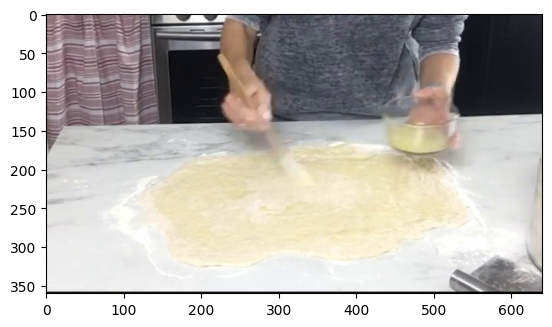

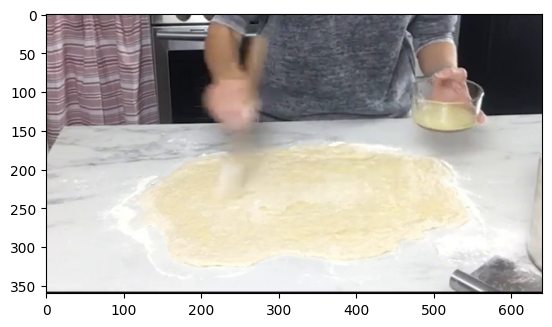

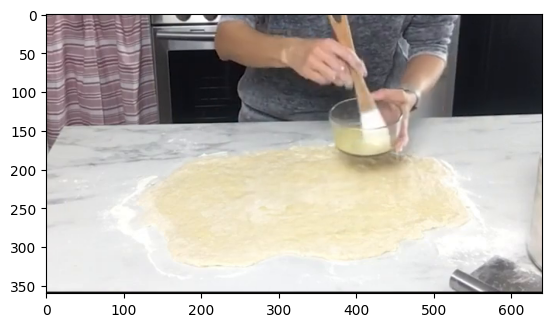

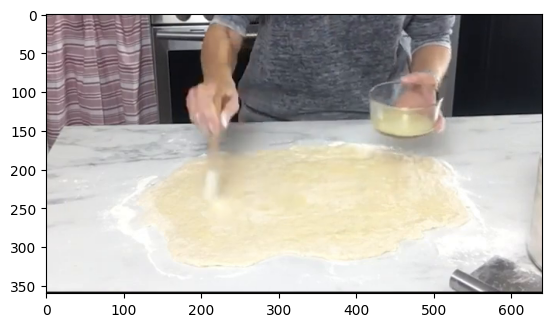

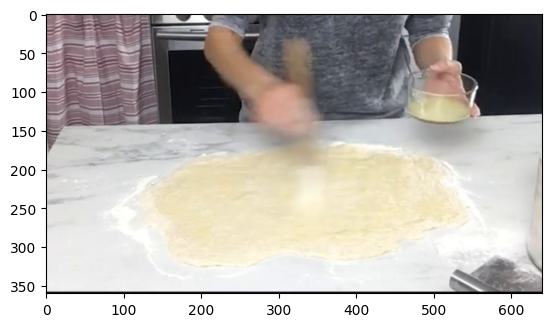

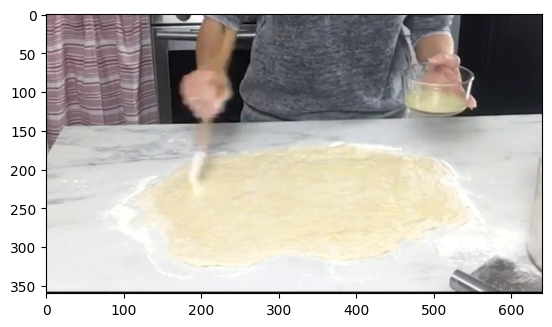

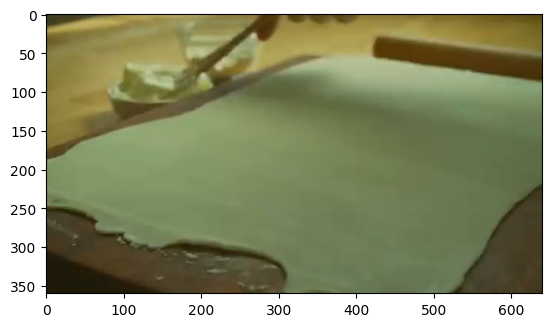

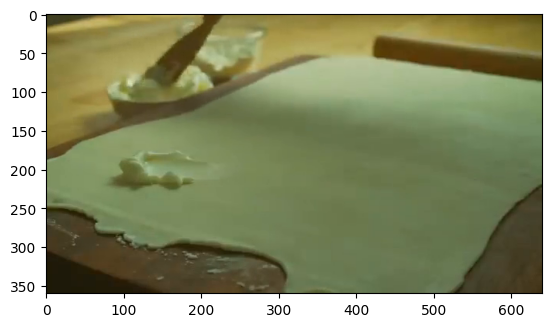

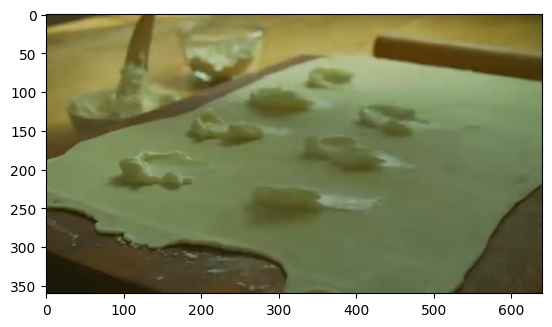

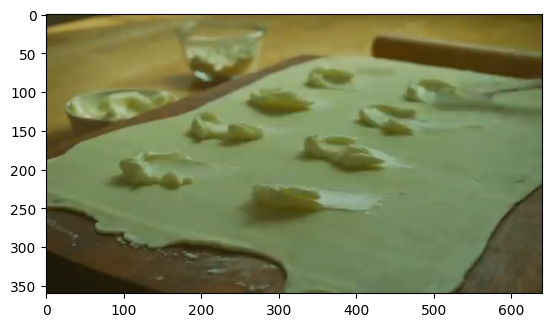

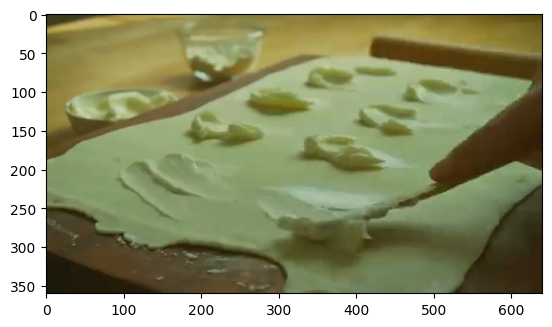

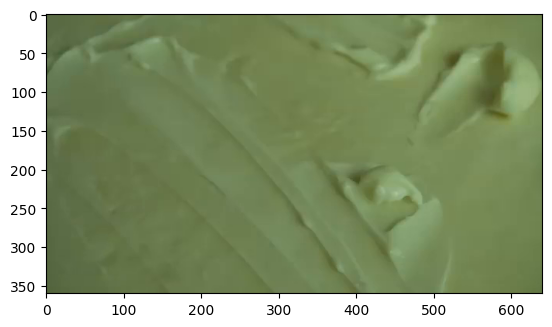

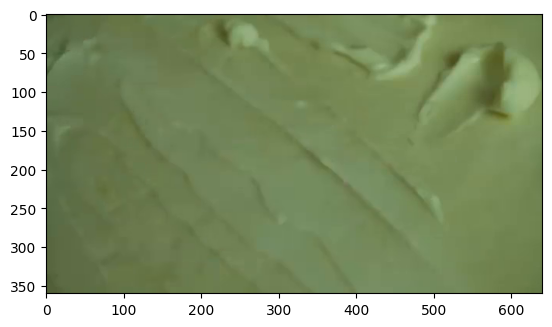

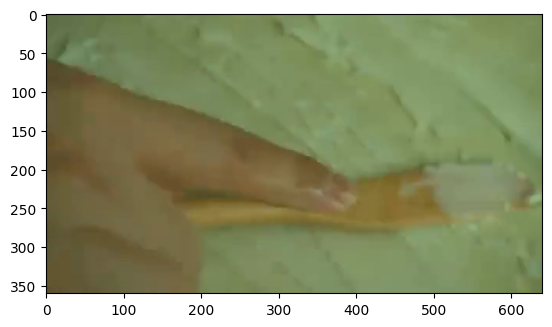

In [ ]:
visualise_frames(combined_video)

In [ ]:
print('Shape of Video 1:', video_1.shape)
print('Shape of Video 2:', video_2.shape)
print('Shape of Concatenated Video:', combined_video.shape)

Shape of Video 1: (8, 360, 640, 3)
Shape of Video 2: (8, 360, 640, 3)
Shape of Concatenated Video: (16, 360, 640, 3)


Input a sequence of frames into the model

In [ ]:
# Example conversation with user question and video reference
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "text",
             "text": "The first 8 images are from Video A, the next 8 from Video B.\
            Please compare the sequence of actions in both videos.\
            Rate their similarity on a scale of 1 (completely different) to 5 (identical), and explain why."},
            {"type": "video"},
        ],
    },
]

More enchansed prompt:

In [ ]:
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": (
                    "You are an expert video analyst. Given 16 frames, where the first 8 are from Video A "
                    "and the next 8 are from Video B, extract and compare key actions.\n\n"
                    "Respond strictly in the following JSON format with no extra text:\n\n"
                    "{\n"
                    "\"Video A Actions\": [\"<Action1>\", \"<Action2>\", ...],\n"
                    "\"Video B Actions\": [\"<Action1>\", \"<Action2>\", ...],\n"
                    "\"Similarity Score (1-5)\": <integer>,\n"
                    "\"Explanation\": \"<short explanation>\"\n"
                    "}\n\n"
                    "If unsure about an action, write \"Unclear\"."
                ),
            },
            {"type": "video"},
        ],
    },
]

In [ ]:
response = generate_video_response(conversation, combined_video, model, processor)

Unused or unrecognized kwargs: return_tensors.


In [ ]:
print(response)

{
"Video Actions": ["Spreading dough onto surface", "Adding toppings to dough", "Rolling dough", "Cutting dough into pieces", "Adding toppings to dough", "Spreading dough onto surface", "Adding toppings to dough", "Rolling dough", "Cutting dough into pieces"],
"Video B Actions": ["Spreading dough onto surface", "Adding toppings to dough", "Rolling dough", "Cutting dough into pieces", "Adding toppings to dough", "Spreading dough onto surface", "Adding toppings to dough", "Rolling dough", "Cutting dough into pieces"],
"Similarity Score (1-5)": 4,
"Explanation": "Both videos show the process of preparing dough for baking, with actions such as spreading, adding toppings, rolling, and cutting. The similarity score is high due to the repetition of these actions in both videos."
}


### Approach 2: Extract Actions, Let the MLLM Compare

In [ ]:
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": (
                    "You are a video understanding expert. Analyze the visual content of this video and list the key actions shown, "
                    "in the order they happen.\n\n"
                    "Respond with a Python-style list of short verb-based actions.\n"
                    "For example: [\"Enter room\", \"Sit down\", \"Pick up phone\"]\n\n"
                    "If actions are unclear, write \"Unclear\" in place of that step.\n"
                    "Keep the list as short and informative as possible — 3 to 6 key steps are enough."
                ),
            },
            {"type": "video"},
        ],
    },
]


In [ ]:
response_1 = generate_video_response(conversation=conversation, video=video_1, model=model, processor=processor)

Unused or unrecognized kwargs: return_tensors.


In [ ]:
print(response_1)

["Prepare dough", "Roll dough", "Spread dough", "Sprinkle topping", "Roll dough", "Sprinkle topping", "Roll dough"]


In [ ]:
response_2 = generate_video_response(conversation=conversation, video=video_2, model=model, processor=processor)

Unused or unrecognized kwargs: return_tensors.


In [ ]:
print(response_2)

["Prepare dough", "Roll dough", "Spread dough", "Cut dough", "Shape dough", "Bake bread"]


Step 2: Compare two lists of actions.

In [ ]:
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": (
                    f"Here are two sequences of actions extracted from two videos.\n\n"
                    f"Video A: {response_1}\n"
                    f"Video B: {response_2}\n\n"
                    "Compare the two sequences based on the order of actions.\n"
                    "Respond strictly in the following JSON format:\n\n"
                    "{\n"
                    "\"Video A Actions\": [...],\n"
                    "\"Video B Actions\": [...],\n"
                    "\"Similarity Score (1-5)\": <integer>,\n"
                    "\"Explanation\": \"<short explanation comparing order and content>\"\n"
                    "}"
                ),
            }
        ],
    },
]

In [ ]:
response = generate_video_response(conversation=conversation, model=model, processor=processor)

In [ ]:
print(response)

{
"Video Actions": [
"Prepare dough",
"Roll dough",
"Spread dough",
"Sprinkle topping",
"Roll dough",
"Sprinkle topping",
"Roll dough"
],
"Video B Actions": [
"Prepare dough",
"Roll dough",
"Spread dough",
"Cut dough",
"Shape dough",
"Bake bread"
],
"Similarity Score (1-5): 4",
"Explanation": "Both videos have similar actions, but in a different order. Both start with preparing the dough, rolling it, and then spreading it. However, Video A adds sprinkling topping after rolling, while Video B cuts and shapes the dough before baking. The order of actions is different, but the content is the same."
}


### Approach 3: Bidirectional Cross-Check

In [ ]:
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": (
                    "You are an expert in video understanding.\n\n"
                    "Your task is to watch this video and extract the key actions shown in it, "
                    "in the order they occur.\n"
                    "Keep your response short, structured, and precise.\n\n"
                    "Respond as a Python-style list of short, verb-based actions like:\n"
                    "[\"Enter room\", \"Pick up phone\", \"Sit down\"]\n\n"
                    "If any actions are unclear, write \"Unclear\" instead.\n"
                    "Limit the list to 3–6 high-level steps that summarize the key activity."
                )
            },
            {
                "type": "video"
            }
        ]
    }
]


In [ ]:
response_1 = generate_video_response(conversation=conversation, video=video_1, model=model, processor=processor)

Unused or unrecognized kwargs: return_tensors.


In [ ]:
print(response_1)

["Mix ingredients", "Roll dough", "Spread topping"]


In [ ]:
response_2 = generate_video_response(conversation=conversation, video=video_2, model=model, processor=processor)

Unused or unrecognized kwargs: return_tensors.


In [ ]:
print(response_2)

["Prepare dough", "Roll dough", "Spread dough", "Cut dough", "Shape dough", "Bake bread"]


Compare Actions A and Video B

In [ ]:
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": (
                    "You are an expert in video understanding and action alignment.\n\n"
                    f"Here is a list of key actions extracted from another video:\n"
                    f"{response_1}\n\n"
                    "Now watch the provided video and determine how well it matches the reference sequence "
                    "in terms of actions and their order.\n\n"
                    "Respond strictly in the following JSON format:\n\n"
                    "{\n"
                    "  \"Similarity Score (1-5)\": <integer>,\n"
                    "  \"Explanation\": \"<brief explanation of how well the actions match>\"\n"
                    "}"
                )
            },
            {
                "type": "video"
            }
        ]
    }
]


In [ ]:
response_AB = generate_video_response(conversation=conversation, video=video_2, model=model, processor=processor)

Unused or unrecognized kwargs: return_tensors.


In [ ]:
print(response_AB)

{
  "Similarity Score (1-5): 4,
  "Explanation": "The actions in the video are in the correct order and align well with the reference sequence. The person is shown mixing ingredients, rolling out the dough, and spreading the topping in a consistent manner, following the steps as described in the reference sequence."
}


Compare Actions B and Video A

In [ ]:
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": (
                    "You are an expert in video understanding and action alignment.\n\n"
                    f"Here is a list of key actions extracted from another video:\n"
                    f"{response_2}\n\n"
                    "Now watch the provided video and determine how well it matches the reference sequence "
                    "in terms of actions and their order.\n\n"
                    "Respond strictly in the following JSON format:\n\n"
                    "{\n"
                    "  \"Similarity Score (1-5)\": <integer>,\n"
                    "  \"Explanation\": \"<brief explanation of how well the actions match>\"\n"
                    "}"
                )
            },
            {
                "type": "video"
            }
        ]
    }
]


In [ ]:
response_BA = generate_video_response(conversation=conversation, video=video_1, model=model, processor=processor)

Unused or unrecognized kwargs: return_tensors.


In [ ]:
print(response_BA)

{
  "Similarity Score (1-5): 4,
  "Explanation": "The actions in the video are in the correct order and align well with the reference sequence. The person is shown mixing ingredients, rolling out the dough, and spreading the topping in a consistent manner, following the steps as described in the reference sequence."
}
